Michael Questions
 - why does finite differences take a 7X12 input as final layer? f_i(x): R^D-> R, no? not R^(DXE)?

In [9]:
# import standard libraries
!pip install autograd
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import autograd.numpy.random as npr
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import sys

# import our libraries
import bayes_helpers as bh
from utils import generate_data
from utils import run_toy_nn
from feed_forward import Feedforward
from nlm import NLM

You should consider upgrading via the '/opt/venv/bin/python -m pip install --upgrade pip' command.


In [124]:
from nlm import NLM
from scipy.optimize import approx_fprime
class LUNA(NLM):
    """
    Fits LUNA Model; inherits from NLM and overrides the objective function
    
    Model Assumptions
     - Weights distributed normally
     - Ys distributed normally

     How to use:
      - run train() to create: 
            a) the NN MLE weights, found in self.ff.weights 
            b) self.posterior samples, the distribution for the weights in the last layer of NLM
     
      - run predict() to get distribution of ys, given x test
    """

    def __init__(self, prior_var, y_noise_var, architecture, random, grad_func = None):
        '''
        Important attributes:
        
        All the NLM attributes

        NN attributes:
            self.D = not exactly sure...
            self.D_in = dimensionality of input data
            self.D_out = dimensionality of output data
            self.H = width of a layer in the NN
        '''

        #inherit from NLM, override objective func
        super().__init__(prior_var, y_noise_var, architecture, random, self.make_objective) 
        self.D, self.D_in, self.D_out, self.H = self.ff.D, architecture['input_dim'], architecture['output_dim'], architecture['width']

        # override default finite difference method for cosine similarity calc (see cos_sim_sq function)
        if grad_func:
            self.grad_func = grad_func
        else:
            self.grad_func = self.default_finite_diff
                
    def similarity_score(self, W, x):
        '''
        Calculates total sum of squared cosine similarity between all pairwise combinations of aux 
        functions
        
        Inputs: 
        - W = NumPy array of weights [dim=(1, width H, input dimension D_in)]

        Returns:
        - score = total cosine similarity squared across all pairs of functions [scalar]

        ''' 

        #D_out = self.D_out
        score = 0

        #derivs of all the aux funcs
        holy_grail = self.grad_func(W, x)

        # in dim x out dim x # obs
        M = holy_grail.shape[1]
        for i in range(self.D_out):
            grad_i = holy_grail[:,i,:]
            for j in range(i + 1, self.D_out):
                grad_j = holy_grail[:,j,:]
                score += self.cos_sim_sq(grad_i, grad_j)
        return score

    def cos_sim_sq(self,grad_i, grad_j):
        numer = np.dot(grad_i, grad_j.T)
        denom = (np.dot(grad_i,grad_i.T)*np.dot(grad_j,grad_j.T))
        return (numer/denom)[0][0]

    
    def default_finite_diff(self,W,x):
        '''
        x.shape[0] is # of dimensions == self.D_in
        x.shape[1] is # of observations

        output: Returns a 3d matrix:
                (in dimension) x (out dimension (# of aux functions)) x (# observations)

                i.e. for each auxillary function and for each observation, approximate the gradient with dimension x.shape[0]
        '''
        
        #create one epsilon for each observation
        eps = np.random.normal(0,0.1,size=x.shape[1])

        #iterate over features of raw input data (rows of x)
        out = np.zeros((self.D_in, self.D_out, x.shape[1]))

        #evaluate function at x
        f_ex = self.ff.forward(W, x)

        assert x.shape[0] == self.D_in

        #for one dimension at a time
        for i in range(x.shape[0]):

            delta = np.zeros(x.shape)
            delta[i,:] = eps

            f_eps = self.ff.forward(W,x+delta)

            # out dim X #obs
            res = (f_eps - f_ex)/eps
            #out[i,:,:] = res[0] # value wise division, different epsilon for each column
            # NEED TO FIX FOR MULTIDIMENSIONAL INPUT DATA

        return res
        
    def mean_mean_sq_error(self, W):
        '''
        Calculates average mean sq error across each output nodes (=the aux functions)
        
        Inputs: 
        - W = NumPy array of all weights [dim=(1, width H, input dimension D_in)]

        Returns:
        - mean_mse = mean of mean sq error for each aux function [scalar]
        ''' 
        D, D_out, H = self.D, self.D_out, self.H
        aux_outputs = self.ff.forward(W, x_train) #shape = (1,10,12)
        Y = np.tile(y_train, D_out).reshape(1, D_out, y_train.shape[1])

        # calculate squared error for each aux regressor, take mean
        mean_mse = np.mean(np.linalg.norm(Y - aux_outputs, axis=1)**2)

        return mean_mse

    def make_objective(self, x_train, y_train, reg_param):
        '''
        Makes objective function and gradient of obj function 
        
        Inputs: 
        - x_train = NumPy array of training data [dim=(1, anything)]
        - y_train = NumPy array of training data [dim=(1, anything)]
        - reg_param = regularization parameter [scalar]

        Returns:
        - objective = function handle for objective function
        - grad(objective) = Autograd gradient of objective function
        ''' 

        def objective(W, t):
            '''
            Calculates objective function: L_luna(model) = L_fit(model) - L_similarity(model)
            L_fit(model) = average mean sq error across all outputs/aux functions
            L_similarity(model) = sum of squared cosine similarity across all aux function combinations
            
            Inputs: 
            - W = NumPy array of all weights [dim=(1, width H, input dimension D_in)]
            - t = necessary for adam solver in Autograd (something about creating a callback)

            Returns:
            - L_fit - L_sim = function handle for objective function [scalar]
            '''
            # L_luna(model) = L_fit(model) - L_similarity(model)
            reg_param = 0.1 #eventually this will become an input
            lambda_ = 0.1 #eventually this will become an input
            L_sim = lambda_*self.similarity_score(W, x_train)

            regularization_penalty = reg_param*np.linalg.norm(W)**2
            mean_mse = self.mean_mean_sq_error(W)
            L_fit = mean_mse - regularization_penalty

            return L_fit - L_sim

        return objective, grad(objective)

### Define Hyperameters

In [125]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 8
hidden_layers = 2
input_dim = 1
output_dim = 5 #number of auxiliary functions

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}
prior_var, y_noise_var = 3.0, 3.0
random = np.random.RandomState(0)
luna = LUNA(prior_var, y_noise_var, architecture, random)

In [126]:
df = pd.read_csv("HW8_data.csv")
x_train = np.array(df["x"])
y_train = np.array(df["y"])
x_test = np.linspace(x_train.min()-1,x_train.max()+1,200)

x_train = x_train.reshape((1, -1))
y_train = y_train.reshape((1, -1))
x_test = x_test.reshape((1, -1))

# 1500 iterations took 5 minutes

# gonna see how 6000 iterations does

# computes approx 5 iterations per second
params = {'step_size':3e-3, 
          'max_iteration':1500, 
          'random_restarts':1,
          'optimizer':'adam'}

luna.train(x_train, y_train, params)

 Iteration 1000 lower bound -183.33283012520295; gradient mag: 9.275704043598614
Done Training


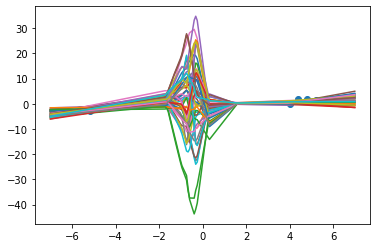

In [127]:
posterior_predictions, posterior_predictive_samples = luna.predict(x_test)
plt.scatter(x_train, y_train)
for i in range(50):
    plt.plot(x_test.flatten(), posterior_predictions[i,:])
plt.show()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

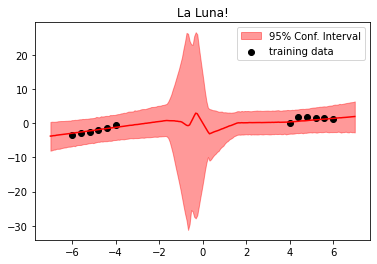

In [128]:
# predict on the test x-values
bh.viz_pp_samples(x_train,y_train,x_test.flatten(),posterior_predictive_samples,'La Luna!')
